In [2]:
"""
This notebook analysis whether DINO distances can be used to predict reconstruction loss at certain token counts.
"""

'\nThis notebook analysis whether DINO distances can be used to predict reconstruction loss at certain token counts.\n'

In [ ]:
import json
import matplotlib.pyplot as plt
import math
import numpy as np

In [3]:
# read dino distances:
with open("/BS/data_mani_compress/work/thesis/thesis/data/datasets/dino_distances/val_categorized/dino_all_centroid_distances_cosine.json") as f:
    dino_distances = json.load(f)

In [5]:
# read reconstruction losses
with open("/BS/data_mani_compress/work/thesis/thesis/data/datasets/imagenet_reconstruction_losses/val_categorized/all_APG_on.json") as f:
    recon_losses = json.load(f)

In [4]:
dd = dino_distances['images']  # get list of distances only

In [10]:
print(len(dd[0]["distances"]))  # print keys of the first entry
print(dd[0]["distances"])  # print keys of the first entry
print(len(dd))
print(dd[0].keys())

1000
[0.9489806890487671, 0.9547814130783081, 0.9584113359451294, 0.9623732566833496, 1.006922721862793, 0.9601420164108276, 1.0636038780212402, 1.0142523050308228, 0.9873754978179932, 0.9736856818199158, 0.9639872908592224, 1.024906039237976, 0.981386661529541, 0.9765211939811707, 0.9780084490776062, 0.9735115170478821, 1.0031836032867432, 0.944340169429779, 0.9965076446533203, 0.9697160124778748, 1.0035593509674072, 0.9804244041442871, 0.9525578022003174, 0.9839141964912415, 1.0107786655426025, 1.0620474815368652, 1.0050066709518433, 0.9454424977302551, 0.9922084212303162, 0.892275333404541, 0.9218693375587463, 0.9218599796295166, 1.0164918899536133, 0.9614852666854858, 0.9551169872283936, 1.00265371799469, 1.0741205215454102, 0.9439424872398376, 1.041709303855896, 1.0038024187088013, 0.9311798810958862, 0.951610267162323, 0.9726982116699219, 0.9807812571525574, 0.9994986653327942, 0.9542015194892883, 0.9898290634155273, 0.9926937818527222, 0.9755059480667114, 0.9987436532974243, 0.9

In [8]:
# find the density for each centroid. loop over all the datapoints and find their centroids, keep increasing
# the count 
# create empty dict
centroid_density = {}
for img in dd:
    centroid = img['nearest_centroid']
    if centroid not in centroid_density:
        centroid_density[centroid] = 0
    centroid_density[centroid] += 1

In [9]:
# find the mean and std of the densities
densities = list(centroid_density.values())
mean_density = np.mean(densities)
std_density = np.std(densities)
print(f"Mean centroid density: {mean_density}, Std: {std_density:.2f}")

Mean centroid density: 50.0, Std: 18.12


Using loss_key=DINOv2FeatureLoss; ks=[1, 2, 4, 8, 16, 32, 64, 128, 256]


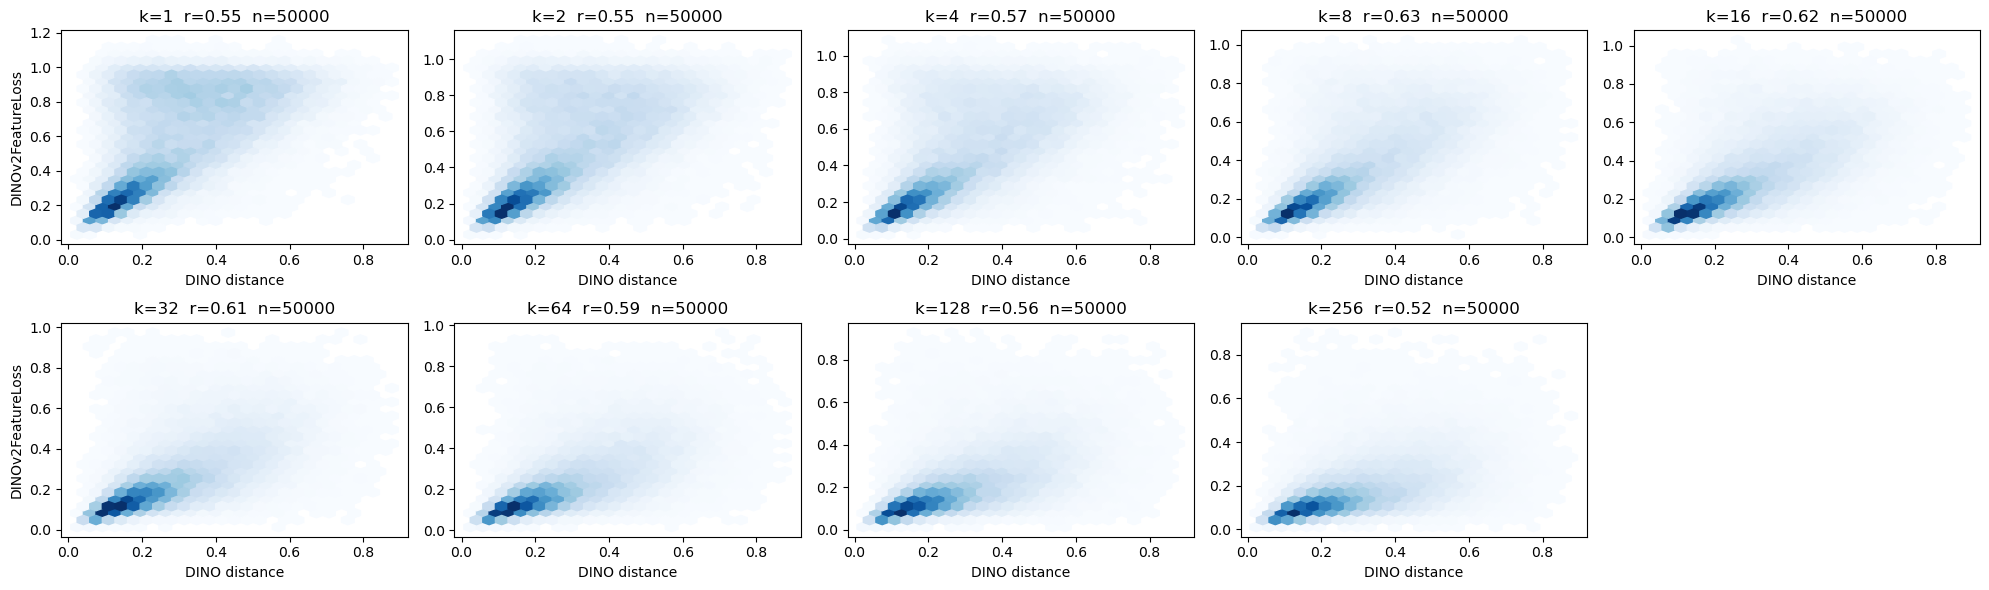

{1: {'n': 50000, 'pearson_r': 0.5466670977704877},
 2: {'n': 50000, 'pearson_r': 0.5501180082026328},
 4: {'n': 50000, 'pearson_r': 0.567426570800138},
 8: {'n': 50000, 'pearson_r': 0.630855802615041},
 16: {'n': 50000, 'pearson_r': 0.624093234935779},
 32: {'n': 50000, 'pearson_r': 0.6110433444923785},
 64: {'n': 50000, 'pearson_r': 0.5905584273110621},
 128: {'n': 50000, 'pearson_r': 0.5602311182655252},
 256: {'n': 50000, 'pearson_r': 0.5199971265550123}}

In [10]:
import torch
from statistics import mean

loss_key = 'DINOv2FeatureLoss'                 # or 'L1Loss' DINOv2FeatureLoss LPIPS
ks = [1, 2, 4, 8, 16, 32, 64, 128, 256]  # token counts to visualize
print(f"Using loss_key={loss_key}; ks={ks}")
corr_list = []

ncols = 5
nrows = int(math.ceil(len(ks) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3), squeeze=False)
axes_f = axes.flatten()

per_k_stats = {}  # {k: {'n': count, 'pearson_r': r}}
for i, k in enumerate(ks):
    ax = axes_f[i]

    # Gather pairs (x=dino_distance, y=loss) for images that match this k and have a LID value
    xs_list, ys_list = [], []
    for rec in recon_losses:
        if int(rec['k_value']) != int(k):
            continue
        img_id = int(rec['image_id'])
        xs_list.append(dd[img_id]["nearest_distance"])       # x-axis: dino distance
        ys_list.append(float(rec[loss_key]))    # y-axis: reconstruction loss

    xs = np.array(xs_list, dtype=float)
    ys = np.array(ys_list, dtype=float)

    if xs.size > 0:
        # Scatter: small markers + transparency to handle dense plots
        ax.hexbin(xs, ys, gridsize=25, cmap='Blues', mincnt=1)

        # Pearson correlation (linear association); guard against zero variance
        corr = float('nan')
        if xs.size > 1 and np.std(xs) > 0 and np.std(ys) > 0:
            corr = np.corrcoef(xs, ys)[0, 1]
        per_k_stats[int(k)] = {'n': int(xs.size), 'pearson_r': corr}
        ax.set_title(f"k={k}  r={corr:.2f}  n={xs.size}")
    else:
        per_k_stats[int(k)] = {'n': 0, 'pearson_r': float('nan')}
        ax.set_title(f"k={k} (no data)")

    corr_list.append(corr)

    # Label axes (reduce clutter: y-label only on first column)
    if i % ncols == 0:
        ax.set_ylabel(loss_key.replace('_', ' '))  # e.g., 'vgg error' or 'mse error'
    ax.set_xlabel('DINO distance')

# Hide any leftover axes in the grid (when ks doesn't fill all slots)
for j in range(len(ks), len(axes_f)):
    axes_f[j].axis('off')

plt.tight_layout()
plt.show()

per_k_stats

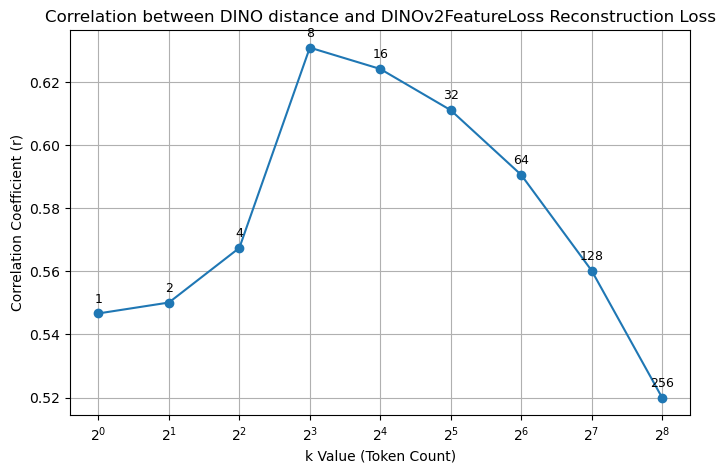

In [15]:
# plot correlation vs k_values
plt.figure(figsize=(8, 5))
plt.plot(ks, corr_list, marker='o')
plt.xscale('log', base=2)
for x, y in zip(ks, corr_list):
    plt.annotate(
        f"{x}",          # text (x value)
        (x, y),          # point to annotate
        textcoords="offset points",
        xytext=(0, 8),   # offset above the point
        ha='center',
        fontsize=9
    )
plt.xlabel('k Value (Token Count)')
plt.ylabel('Correlation Coefficient (r)')
plt.title('Correlation between DINO distance and DINOv2FeatureLoss Reconstruction Loss')
plt.grid(True)
plt.show()